In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""flags, file path, and file names for saving data and figures"""

# have data file already?
have_data_file = False  # if True, load data from file
                        # if False, run simulation (and save data)

if have_data_file:
    # load data from this path (including file name)
    data_path = 'YOUR LOCAL DIRECTORY WHERE DATA FILE IS ALREADY SAVED'
else:
    # save simulated data?
    save_data = False
    # file name for new simulated data to be saved
    filename_data = 'data-cue-combination_yyyy-mm-dd.npz'

# save simulated data and/or figure panel(s) to this path (excluding file name)
save2path = 'YOUR LOCAL DIRECTORY FOR SAVING FILES'

# save figure panel 5f?
save_fig5f = False
# save figure panel 5g?
save_fig5g = False
# figure panel file format, e.g. 'pdf', 'eps', 'svg'
fig_format = 'pdf'
# figure panel file names
filename_fig5f = 'fig5f-cue-combination_yyyy-mm-dd'
filename_fig5g = 'fig5g-cue-combination_yyyy-mm-dd'

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from ra_network import RingAttractorNetwork, \
    back_to_circ, movmean, plot_all, sliding_window, offset_variation, \
        generate_ground_truth, generate_ER_input, generate_AV_input_noise, generate_ER_input_noise

In [4]:
# plotting parameters

mpl.rcParams.update({
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
    })

%matplotlib inline

In [5]:
# ring attractor network parameters

network_params = {
    'N' : 32,                               # number of neurons
    'tau': 0.05,                            # network time constant [s]
    'alpha': -8.93,                         # self-excitation parameter
    'D' : 5.19,                             # nearest-neighbor excitation
    'beta' : 0.11,                          # global inhibition parameter
    'f_act' : lambda x: np.maximum(0,x+1),  # activation function
    'v_rel' : 3.64 ,                        # angular velocity conversion factor
    'dt' : 0.0025                           # step size [s]
    }

In [6]:
"""specify simulation parameters"""

n_sims = 100
rng_seeds = [random.randrange(2**32-1) for k in range(n_sims)]

# specify gamma decay parameter
gamma_decay = 17

# ER input noise parameters
ER_baseline_factor = 0.45

# simulation time parameters
T_burn_in = 30          # time interval (burn-in) when cue is off for weight matrix to reach steady state [s]
T_cue_1_init = 25       # length of initial block when only cue 1 is on [s]
T_cue_2_init = 25       # length of initial block when only cue 2 is on [s]
T_both_cues = 32.5      # length of block when both cues are on [s]
T_cue_1_final = 12.5    # length of final block when only cue 2 is on [s]
T_cue_2_final = 12.5    # length of final block when only cue 2 is on [s]

t_cue_1_onset_init = T_burn_in                              # onset of initial block when only cue 1 is on [s]
t_cue_2_onset_init = t_cue_1_onset_init + T_cue_1_init      # onset of initial block when only cue 2 is on [s]
t_both_cues_onset = t_cue_2_onset_init + T_cue_2_init       # onset of block when both cues are on [s]
t_cue_1_onset_final = t_both_cues_onset + T_both_cues       # onset of final block when only cue 1 is on [s]
t_cue_2_onset_final = t_cue_1_onset_final + T_cue_1_final   # onset of final block when only cue 2 is on [s]
T = t_cue_2_onset_final + T_cue_2_final - T_burn_in         # total length of simulation excluding burn in [s]

# specify window size for computing offset variability
windowsize_offset_variability = 3200  # [steps], equivalent to 8 [s] in simulation

# specify standard deviation of Gaussian kernel for smoothing ER->EPG weight matrix
sigma_smooth = 2

# specify initial weight norm
W_norm_init = 1.5


"""create ring attractor object"""

ra = RingAttractorNetwork(network_params)

ra.gamma_Hebb = 1
ra.gamma_postboost = 1
ra.gamma_decay = gamma_decay
ra.eta = 5e-5

ra.gamma_Hebb_2 = 1
ra.gamma_postboost_2 = 1
ra.gamma_decay_2 = gamma_decay

h0, w0 = ra.determine_features_basic()
#ER_amplitude = h0 * ER_amplitude_scale
ER_baseline = ER_baseline_factor * np.sum(ra.r_init)

In [7]:
"""simulation"""

if not have_data_file:
    # initialize data arrays for main figure
    offset_variability_array = np.full((n_sims, int(T/ra.dt)), np.nan)
    bump_width_array = np.full((n_sims, int(T/ra.dt)), np.nan)
    bump_amplitude_array = np.full((n_sims, int(T/ra.dt)), np.nan)
    W_notch_depth_array = np.full((n_sims, int(T/ra.dt)), np.nan)
    W2_notch_depth_array = np.full((n_sims, int(T/ra.dt)), np.nan)

    # initialize data arrays for auxilliary plots
    W_norm_array = np.full((n_sims, int(T/ra.dt)), np.nan)
    W2_norm_array = np.full((n_sims, int(T/ra.dt)), np.nan)

    for i in tqdm(range(n_sims)):
        ra.reset_network()

        # generate ground truth AV input and HD for learning
        v_AV, z_HD = generate_ground_truth(ra.dt, T_burn_in + T)

        # generate ER input associated with cue 1
        g1, _, _ = generate_ER_input(ra, T_burn_in + T, v_AV, z_HD)
        g2 = np.copy(g1)

        # turn off ER input when associated cue is off
        g1[:int(t_cue_1_onset_init / ra.dt)] = 0                                     # cue 1 is off in burn-in and no-cue period
        g2[:int(t_cue_2_onset_init / ra.dt)] = 0                                     # cue 2 is off in burn-in, no-cue period, and initial cue 1 block
        g1[int(t_cue_2_onset_init / ra.dt) : int(t_both_cues_onset / ra.dt)] = 0     # cue 1 is off in initial cue 2 block
        g2[int(t_cue_1_onset_final / ra.dt) : int(t_cue_2_onset_final / ra.dt)] = 0  # cue 2 is off in final cue 1 block
        g1[int(t_cue_2_onset_final / ra.dt):] = 0                                    # cue 1 is off in final cue 2 block

        # generate AV input noise
        noise_AV = generate_AV_input_noise(ra.dt, T_burn_in + T)

        # generate ER input noise associated with cue 1
        noise_g1 = generate_ER_input_noise(g1)              # generate uniform input noise
        noise_g1 = noise_g1.T / np.sum(noise_g1, axis=1)    # normalize by sum, shape (ra.N, int(T/ra.dt))
        noise_g1 = ER_baseline * noise_g1                   # scale by constant ER baseline, independent of ER activity
        noise_g1 = noise_g1.T                               # shape (int(T/ra.dt), ra.N)

        # generate ER input noise associated with cue 2
        noise_g2 = generate_ER_input_noise(g2)
        noise_g2 = noise_g2.T / np.sum(noise_g2, axis=1)
        noise_g2 = ER_baseline * noise_g2
        noise_g2 = noise_g2.T

        # initialize weight matrix associated with cue 1
        ra.W = np.random.uniform(0, 1, (ra.N, ra.N))
        ra.W = W_norm_init * ra.W / np.linalg.norm(ra.W)

        # initialize weight matrix associated with cue 2
        ra.W2 = np.random.uniform(0, 1, (ra.N, ra.N))
        ra.W2 = W_norm_init * ra.W2 / np.linalg.norm(ra.W2)

        # learn weight matrix
        ra.simulate_two_cues(T_burn_in + T, v = v_AV + noise_AV, g = g1 + noise_g1, g2 = g2 + noise_g2, learn=True, trace=True)

        # extract bump position and compute offset
        bump_pos = ra.determine_bumpPosition(ydata=ra.r_trace)

        # get ER->EPG weight matrices across time
        W_trace = ra.W_trace.copy()
        W2_trace = ra.W2_trace.copy()

        # compute Frobenius norm of weight matrix
        W_norm_array[i] = np.linalg.norm(ra.W_trace[int(T_burn_in/ra.dt):], axis=(1, 2))
        W2_norm_array[i] = np.linalg.norm(ra.W2_trace[int(T_burn_in/ra.dt):], axis=(1, 2))

        for tt in range(int(T/ra.dt)):
            t = tt + int(T_burn_in/ra.dt)

            # extract bump parameters
            bump_amplitude_array[i, tt], bump_width_array[i, tt] = ra.determine_features_basic(ind=t)

            # compute offset variability
            window_bump_pos = sliding_window(bump_pos, t, windowsize_offset_variability)
            window_z = sliding_window(z_HD, t, windowsize_offset_variability)
            offset_variability_array[i, tt] = offset_variation(window_bump_pos, window_z)

            # smooth ER->EPG weight matrix with Gaussian filter
            W_smoothed = gaussian_filter(W_trace[t], sigma_smooth, mode = 'wrap')
            W2_smoothed = gaussian_filter(W2_trace[t], sigma_smooth, mode = 'wrap')

            # compute weight matrix notch depth, i.e. max-min
            W_notch_depth_array[i, tt] = np.max(W_smoothed) - np.min(W_smoothed)
            W2_notch_depth_array[i, tt] = np.max(W2_smoothed) - np.min(W2_smoothed)

    # compute HD encoding accuracy from offset variability
    HD_encoding_accuracy_array = 1 - offset_variability_array


100%|██████████| 100/100 [17:23<00:00, 10.44s/it]


In [8]:
"""save data arrays"""

if have_data_file:
    pass
else:
    if save_data:
        np.savez(os.path.join(save2path, filename_data),
            offset_variability_array = offset_variability_array,
            bump_width_array = bump_width_array,
            bump_amplitude_array = bump_amplitude_array,
            W_notch_depth_array = W_notch_depth_array,
            W2_notch_depth_array = W2_notch_depth_array,
            W_norm_array = W_norm_array,
            W2_norm_array = W2_norm_array
        )

In [9]:
"""load data"""

if have_data_file:
    with np.load(data_path) as data_arrays:
        offset_variability_array = data_arrays['offset_variability_array'],
        bump_width_array = data_arrays['bump_width_array'],
        bump_amplitude_array = data_arrays['bump_amplitude_array'],
        W_notch_depth_array = data_arrays['W_notch_depth_array'],
        W2_notch_depth_array = data_arrays['W2_notch_depth_array'],
        W_norm_array = data_arrays['W_norm_array'],
        W2_norm_array = data_arrays['W2_norm_array']

    offset_variability_array = offset_variability_array[0]
    bump_width_array = bump_width_array[0]
    bump_amplitude_array = bump_amplitude_array[0]
    W_notch_depth_array = W_notch_depth_array[0]
    W2_notch_depth_array = W2_notch_depth_array[0]
    W_norm_array = W_norm_array[0]
    W2_norm_array = W2_norm_array[0]

    HD_encoding_accuracy_array = 1 - offset_variability_array

In [10]:
'''average across simulations'''

offset_variability_mean = np.mean(offset_variability_array, axis=0)
offset_variability_sem = np.std(offset_variability_array, axis=0) / np.sqrt(n_sims)

HD_encoding_accuracy_mean = np.mean(HD_encoding_accuracy_array, axis=0)
HD_encoding_accuracy_sem = np.std(HD_encoding_accuracy_array, axis=0) / np.sqrt(n_sims)

bump_width_mean = np.mean(bump_width_array, axis=0)
bump_width_sem = np.std(bump_width_array, axis=0) / np.sqrt(n_sims)

bump_amplitude_mean = np.mean(bump_amplitude_array, axis=0)
bump_amplitude_sem = np.std(bump_amplitude_array, axis=0) / np.sqrt(n_sims)

W_notch_depth_mean = np.mean(W_notch_depth_array, axis=0)
W_notch_depth_sem = np.std(W_notch_depth_array, axis=0) / np.sqrt(n_sims)

W2_notch_depth_mean = np.mean(W2_notch_depth_array, axis=0)
W2_notch_depth_sem = np.std(W2_notch_depth_array, axis=0) / np.sqrt(n_sims)

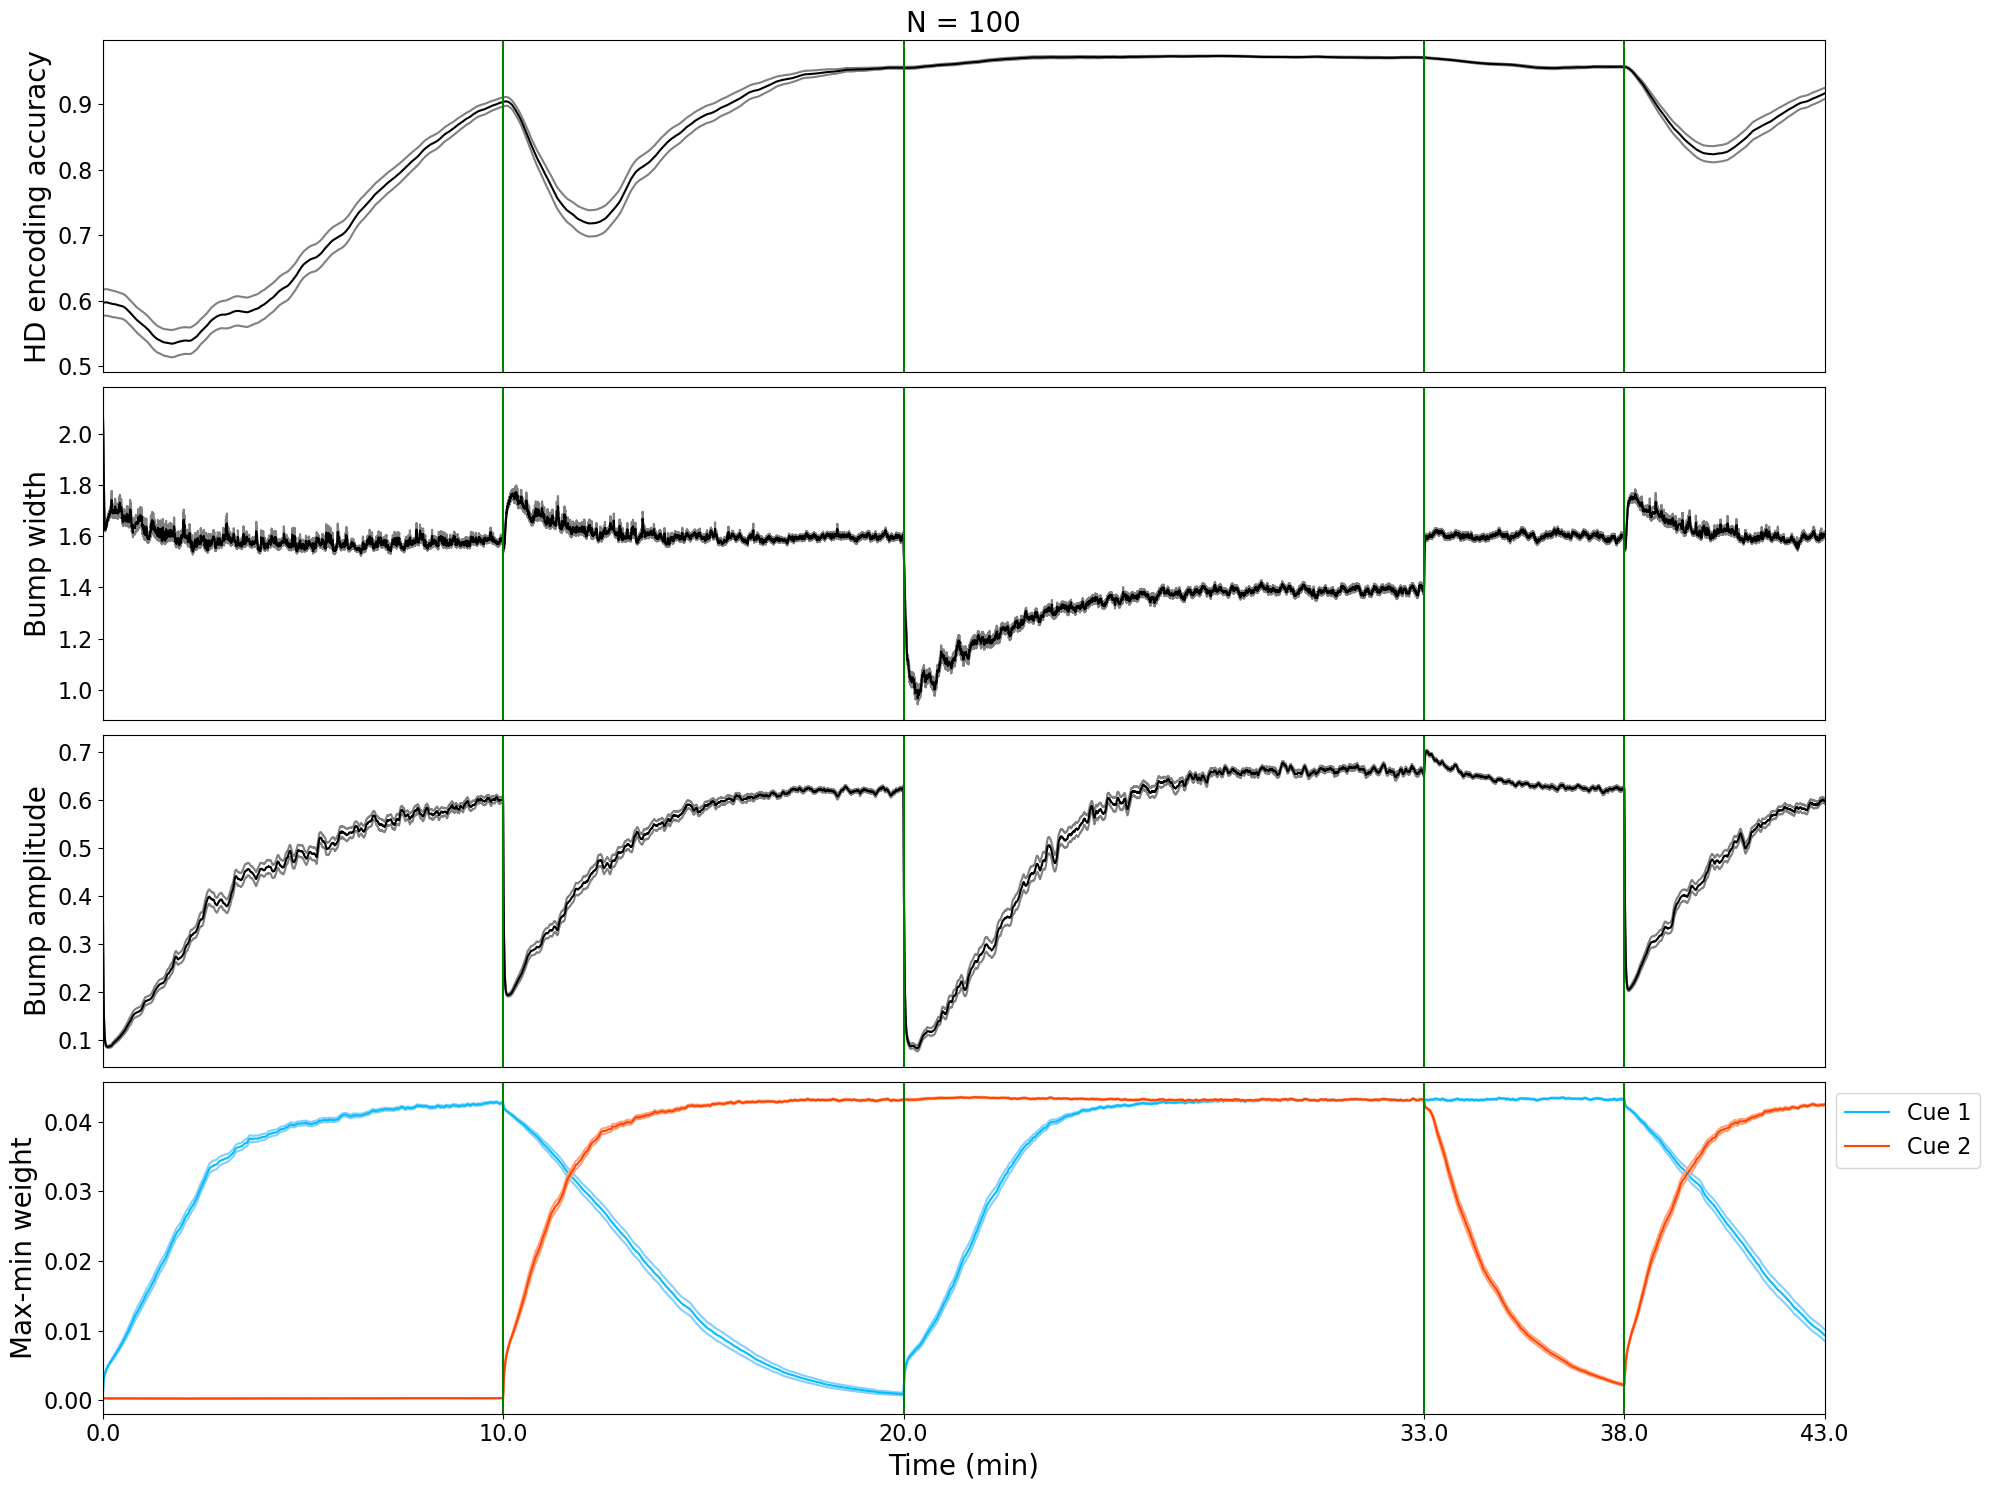

In [11]:
"""visualization - figure 5f"""

plot_fig5f = True

rescale_time_model2experiment = 24  # conversion factor to go from simulation time to real time
units_minutes = True                # units are in minutes?


if plot_fig5f:
    """specify time axis tick marks and labels"""

    # array of tick locations along time axis
    xtick_locations = np.array([t_cue_1_onset_init, t_cue_2_onset_init, t_both_cues_onset, t_cue_1_onset_final, t_cue_2_onset_final, T_burn_in + T])
    xtick_locations -= T_burn_in    # subtract burn-in period

    # array of tick labels along time axis
    xtick_labels = xtick_locations * rescale_time_model2experiment  # convert from simulation time to real time
    if units_minutes:
        xtick_labels /= 60  # convert from seconds to minutes


    """generate figure"""

    fig_5f, ax_5f = plt.subplots(4, 1, figsize=(20, 15))

    ax_5f[0].set_title(f'N = {n_sims}')

    # plot HD encoding accuracy vs. time
    ax_5f[0].plot(np.arange(0, T, ra.dt), HD_encoding_accuracy_mean - HD_encoding_accuracy_sem, color='gray')
    ax_5f[0].plot(np.arange(0, T, ra.dt), HD_encoding_accuracy_mean + HD_encoding_accuracy_sem, color='gray')
    ax_5f[0].plot(np.arange(0, T, ra.dt), HD_encoding_accuracy_mean, color='k')
#    ax_5f[0].fill_between(np.arange(0, T, ra.dt),
#        HD_encoding_accuracy_mean - HD_encoding_accuracy_sem, HD_encoding_accuracy_mean + HD_encoding_accuracy_sem, 
#        color='gray', alpha=0.5
#        )

    ax_5f[0].axvline(t_cue_1_onset_init - T_burn_in, color='green')
    ax_5f[0].axvline(t_cue_2_onset_init - T_burn_in, color='green')
    ax_5f[0].axvline(t_both_cues_onset - T_burn_in, color='green')
    ax_5f[0].axvline(t_cue_1_onset_final - T_burn_in, color='green')
    ax_5f[0].axvline(t_cue_2_onset_final - T_burn_in, color='green')

    ax_5f[0].set_ylabel('HD encoding accuracy')
    ax_5f[0].set_xlim(0, T)
    ax_5f[0].set_xticks([])

    # plot bump width vs. time
    ax_5f[1].plot(np.arange(0, T, ra.dt), bump_width_mean - bump_width_sem, color='gray')
    ax_5f[1].plot(np.arange(0, T, ra.dt), bump_width_mean + bump_width_sem, color='gray')
    ax_5f[1].plot(np.arange(0, T, ra.dt), bump_width_mean, color='k')
#    ax_5f[1].fill_between(np.arange(0, T, ra.dt),
#        bump_width_mean - bump_width_sem, bump_width_mean + bump_width_sem,
#        color='gray', alpha=0.5
#    )

    ax_5f[1].axvline(t_cue_1_onset_init - T_burn_in, color='green')
    ax_5f[1].axvline(t_cue_2_onset_init - T_burn_in, color='green')
    ax_5f[1].axvline(t_both_cues_onset - T_burn_in, color='green')
    ax_5f[1].axvline(t_cue_1_onset_final - T_burn_in, color='green')
    ax_5f[1].axvline(t_cue_2_onset_final - T_burn_in, color='green')

    ax_5f[1].set_ylabel('Bump width')
    ax_5f[1].set_xlim(0, T)
    ax_5f[1].set_xticks([])

    # plot bump amplitude vs. time
    ax_5f[2].plot(np.arange(0, T, ra.dt), bump_amplitude_mean - bump_amplitude_sem, color='gray')
    ax_5f[2].plot(np.arange(0, T, ra.dt), bump_amplitude_mean + bump_amplitude_sem, color='gray')
    ax_5f[2].plot(np.arange(0, T, ra.dt), bump_amplitude_mean, color='k')
#    ax_5f[2].fill_between(np.arange(0, T, ra.dt),
#        bump_amplitude_mean - bump_amplitude_sem, bump_amplitude_mean + bump_amplitude_sem,
#        color='gray', alpha=0.5
#    )

    ax_5f[2].axvline(t_cue_1_onset_init - T_burn_in, color='green')
    ax_5f[2].axvline(t_cue_2_onset_init - T_burn_in, color='green')
    ax_5f[2].axvline(t_both_cues_onset - T_burn_in, color='green')
    ax_5f[2].axvline(t_cue_1_onset_final - T_burn_in, color='green')
    ax_5f[2].axvline(t_cue_2_onset_final - T_burn_in, color='green')

    ax_5f[2].set_ylabel('Bump amplitude')
    ax_5f[2].set_xlim(0, T)
    ax_5f[2].set_xticks(xtick_locations, labels=None)
    ax_5f[2].set_xticks([])

    # plot notch depth (max - min) vs. time
    ax_5f[3].plot(np.arange(0, T, ra.dt), W_notch_depth_mean - W_notch_depth_sem, color='lightskyblue')
    ax_5f[3].plot(np.arange(0, T, ra.dt), W_notch_depth_mean + W_notch_depth_sem, color='lightskyblue')
    ax_5f[3].plot(np.arange(0, T, ra.dt), W_notch_depth_mean, color='deepskyblue', label='Cue 1')
#    ax_5f[3].fill_between(np.arange(0, T, ra.dt),
#        W_notch_depth_mean - W_notch_depth_sem, W_notch_depth_mean + W_notch_depth_sem,
#        color='deepskyblue', alpha=0.3
#    )

    ax_5f[3].plot(np.arange(0, T, ra.dt), W2_notch_depth_mean - W2_notch_depth_sem, color='lightsalmon')
    ax_5f[3].plot(np.arange(0, T, ra.dt), W2_notch_depth_mean + W2_notch_depth_sem, color='lightsalmon')
    ax_5f[3].plot(np.arange(0, T, ra.dt), W2_notch_depth_mean, color='orangered', label='Cue 2')
#    ax_5f[3].fill_between(np.arange(0, T, ra.dt),
#        W2_notch_depth_mean - W2_notch_depth_sem, W2_notch_depth_mean + W2_notch_depth_sem,
#        color='orangered', alpha=0.3
#    )

    ax_5f[3].legend(bbox_to_anchor=(1, 1), loc='upper left')

    ax_5f[3].axvline(t_cue_1_onset_init - T_burn_in, color='green')
    ax_5f[3].axvline(t_cue_2_onset_init - T_burn_in, color='green')
    ax_5f[3].axvline(t_both_cues_onset - T_burn_in, color='green')
    ax_5f[3].axvline(t_cue_1_onset_final - T_burn_in, color='green')
    ax_5f[3].axvline(t_cue_2_onset_final - T_burn_in, color='green')

    ax_5f[3].set_ylabel('Max-min weight')
    ax_5f[3].set_xlim(0, T)
    ax_5f[3].set_xticks(xtick_locations)
    ax_5f[3].set_xticklabels(xtick_labels)

    ax_5f[3].set_xlabel('Time (min)')

    plt.tight_layout()

In [12]:
"""example simulation run to show evolution of weight matrices"""

# if data file is available (and hence simulations were not re-run)
# then run a single simulation to show the weight matrices at different time points
# if instead data file is unavailable and n_sims simulations were run
# then this cell is skipped and the last run from the simulations above is used

if have_data_file:

    ra.reset_network()

    # generate ground truth AV input and HD for learning
    v_AV, z_HD = generate_ground_truth(ra.dt, T_burn_in + T)

    # generate ER input associated with cue 1
    g1, _, _ = generate_ER_input(ra, T_burn_in + T, v_AV, z_HD)
    g2 = np.copy(g1)

    # turn off ER input when associated cue is off
    g1[:int(t_cue_1_onset_init / ra.dt)] = 0                                     # cue 1 is off in burn-in and no-cue period
    g2[:int(t_cue_2_onset_init / ra.dt)] = 0                                     # cue 2 is off in burn-in, no-cue period, and initial cue 1 block
    g1[int(t_cue_2_onset_init / ra.dt) : int(t_both_cues_onset / ra.dt)] = 0     # cue 1 is off in initial cue 2 block
    g2[int(t_cue_1_onset_final / ra.dt) : int(t_cue_2_onset_final / ra.dt)] = 0  # cue 2 is off in final cue 1 block
    g1[int(t_cue_2_onset_final / ra.dt):] = 0                                    # cue 1 is off in final cue 2 block

    # generate AV input noise
    noise_AV = generate_AV_input_noise(ra.dt, T_burn_in + T)

    # generate ER input noise associated with cue 1
    noise_g1 = generate_ER_input_noise(g1)              # generate uniform input noise
    noise_g1 = noise_g1.T / np.sum(noise_g1, axis=1)    # normalize by sum, shape (ra.N, int(T/ra.dt))
    noise_g1 = ER_baseline * noise_g1                   # scale by constant ER baseline, independent of ER activity
    noise_g1 = noise_g1.T                               # shape (int(T/ra.dt), ra.N)

    # generate ER input noise associated with cue 2
    noise_g2 = generate_ER_input_noise(g2)
    noise_g2 = noise_g2.T / np.sum(noise_g2, axis=1)
    noise_g2 = ER_baseline * noise_g2
    noise_g2 = noise_g2.T

    # initialize weight matrix associated with cue 1
    ra.W = np.random.uniform(0, 1, (ra.N, ra.N))
    ra.W = W_norm_init * ra.W / np.linalg.norm(ra.W)

    # initialize weight matrix associated with cue 2
    ra.W2 = np.random.uniform(0, 1, (ra.N, ra.N))
    ra.W2 = W_norm_init * ra.W2 / np.linalg.norm(ra.W2)

    # learn weight matrix
    ra.simulate_two_cues(T_burn_in + T, v = v_AV + noise_AV, g = g1 + noise_g1, g2 = g2 + noise_g2, learn=True, trace=True)

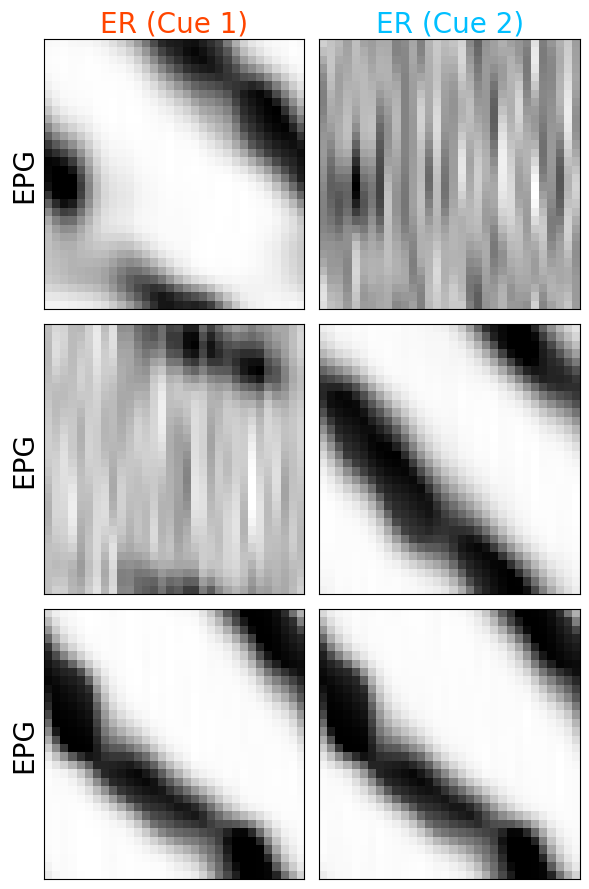

In [13]:
"""visualization - figure 5g"""

plot_fig5g = True

if plot_fig5g:
    fig_5g, ax_5g = plt.subplots(3, 2, figsize=(6, 9))

    '''weight matrix associated with cue 1'''

    # end of initial cue 1 only block
    im1_cue_1_end = ax_5g[0, 0].imshow(ra.W_trace[int(t_cue_2_onset_init / ra.dt)], aspect='auto', cmap='gray')
    ax_5g[0, 0].set_xticks([])
    ax_5g[0, 0].set_yticks([])
    ax_5g[0, 0].set_ylabel('EPG')
    ax_5g[0, 0].set_title('ER (Cue 1)', color='orangered')

    # end of initial cue 2 only block
    im1_cue_2_end = ax_5g[1, 0].imshow(ra.W_trace[int(t_both_cues_onset / ra.dt)], aspect='auto', cmap='gray')
    ax_5g[1, 0].set_xticks([])
    ax_5g[1, 0].set_yticks([])
    ax_5g[1, 0].set_ylabel('EPG')

    # end of block with both cues
    im1_both_cues_end = ax_5g[2, 0].imshow(ra.W_trace[int(t_cue_1_onset_final / ra.dt)], aspect='auto', cmap='gray')
    ax_5g[2, 0].set_xticks([])
    ax_5g[2, 0].set_yticks([])
    ax_5g[2, 0].set_ylabel('EPG')

    '''weight matrix associated with cue 2'''

    # end of initial cue 1 only block
    im2_cue_1_end = ax_5g[0, 1].imshow(ra.W2_trace[int(t_cue_2_onset_init / ra.dt)], aspect='auto', cmap='gray')
    ax_5g[0, 1].set_xticks([])
    ax_5g[0, 1].set_yticks([])
    ax_5g[0, 1].set_title('ER (Cue 2)', color='deepskyblue')

    # end of initial cue 2 only block
    im2_cue_2_end = ax_5g[1, 1].imshow(ra.W2_trace[int(t_both_cues_onset / ra.dt)], aspect='auto', cmap='gray')
    ax_5g[1, 1].set_xticks([])
    ax_5g[1, 1].set_yticks([])

    # end of block with both cues
    im2_both_cues = ax_5g[2, 1].imshow(ra.W2_trace[int(t_cue_1_onset_final / ra.dt)], aspect='auto', cmap='gray')
    ax_5g[2, 1].set_xticks([])
    ax_5g[2, 1].set_yticks([])

    plt.tight_layout()

In [14]:
"""save figures"""

if save_fig5f:
    fig_5f.savefig(os.path.join(save2path, filename_fig5f + '.' + fig_format), format=fig_format)

if save_fig5g:
    fig_5g.savefig(os.path.join(save2path, filename_fig5g + '.' + fig_format), format=fig_format)